# Pylops - Seismic interpolation with FK masks

### Author: M.Ravasi

In this notebook I will consider the problem of seismic interpolation of regularly aliased data and use fk masks derived from low-frequency unaliased data to drive the solution at high-frequency aliased data.

Given the data $\mathbf{d}$, sampling operator $\mathbf{R}$, fk transform $S_{fk}$, and model in fk domain $\mathbf{m}$ the forward problem is:

$$
\mathbf{d} = \mathbf{R}\mathbf{S}_{fk}^H \mathbf{m}
$$

The overall algorithm proceeds as follows

1) Low pass the data for $f<f_{alias}$, $\mathbf{d}_{low}$ and find sparse basis $\mathbf{m}_{low}$:

$$
\mathbf{m}_{low} = arg min ||\mathbf{d}_{low} - \mathbf{S}_{fk}^H \mathbf{m}_{low}|| + \epsilon ||\mathbf{m}_{low}||_1
$$

2) From the low frequency solution find a fk mask $\mathbf{M}_{fk}$ where events are expect it and extent it to high freqs

3) Use the mask to invert for full spectrum using $\mathbf{m}_{low}$ as starting guess:

$$
\mathbf{m} = arg min ||\mathbf{d} - \mathbf{S}_{fk}^H \mathbf{M}_{fk} \mathbf{m}|| + \epsilon ||\mathbf{m}||_1
$$

4) Run a few iterations without mask using using $\mathbf{m}$ as starting guess:

$$
\mathbf{m} = arg min ||\mathbf{d} - \mathbf{S}_{fk}^H \mathbf{m}|| + \epsilon ||\mathbf{m}||_1
$$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import warnings
#warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pylops

from scipy.signal import filtfilt
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing           import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity      import *

In [2]:
def masked_interpolation(y, nx, dt, dx, nfft_f, nfft_k, sub,
                         vel=1500, critical=1.00, koffset=0.0, fmax=15., 
                         eventthresh=0.3, nsmooth = 4,
                         niters=(20, 20, 10), eps=(1e-2, 1e-2, 1e-3), 
                         solver='FISTA'):
    # Dimensions
    _, nt = y.shape
    
    # Restriction operator
    iava = np.arange(nx)[::sub]    
    Rop = Restriction(dims=(nx, nt), iava=iava, axis=0, dtype='float64')
    ylow = Rop.H * y.ravel()
    ylow = ylow.reshape(nx, nt)
    
    # FK operator
    FFTop = FFT2D(dims=[nx, nt], nffts=[nfft_k, nfft_f], sampling=[dx, dt])
    ks, f = FFTop.f1, FFTop.f2
    
    # Low-frequency mask
    fmask = np.zeros(nfft_f)
    fmask[np.abs(f)<fmax] = 1

    [kx, ff] = np.meshgrid(ks, f, indexing='ij')
    mask = np.abs(kx) < (critical*np.abs(ff)/vel + koffset)
    mask = mask.T
    mask *= fmask[:, np.newaxis].astype(bool)
    mask = mask.astype(np.int64)
    
    # Low-pass data
    Y = FFTop * ylow.flatten()
    Y = np.reshape(Y, (nfft_k, nfft_f))

    Ylow = Y * mask.T
    ylow = FFTop.H * Ylow.ravel()
    ylow = np.real(ylow).reshape(nx, nt)
    
    # Inversion on low-passed data (to get starting guess)
    Mf = Diagonal(mask.T.astype(np.int64))
    if solver == 'FISTA':
        Xinvlow, _, cost = fista(FFTop.H, ylow.ravel(), niter=niters[0], 
                                 eps=eps[0], alpha=1, show=True)
    elif solver == 'IRLS':
        print('use IRLS')
        Xinvlow = irls(FFTop.H, ylow.ravel(), nouter=niters[0]//2, epsR=eps[0], kind='model', 
                       **dict(iter_lim=niters[0]//2))[0]
    xinvlow = FFTop.H * Xinvlow
    Xinvlow = Xinvlow.reshape(nfft_k, nfft_f)
    xinvlow = np.real(xinvlow).reshape(nx, nt)
    
    # FK events mask
    fsel = fmax-1
    df = 1./(dt*nfft_f)
    dk = 1./(dx*nfft_k)
    ifsel = int(fsel/df)
    Xinvlow_freq = np.abs(np.fft.fftshift(Xinvlow[:, ifsel]))
    Xinvlow_selection = np.zeros(Xinvlow_freq.size)
    Xinvlow_selection[Xinvlow_freq > (eventthresh * Xinvlow_freq.max())] = 1.

    eventmask = np.zeros((nfft_f, nfft_k))
    for ievent in np.where(Xinvlow_selection==1)[0]:
        kx_event = np.fft.fftshift(FFTop.f1)[ievent]
        slope = kx_event / f[ifsel]
        eventmask[np.arange(nfft_f), (f*slope/dk).astype(np.int64)] = 1.
    eventmask = filtfilt(np.ones(nsmooth)/nsmooth, 1, eventmask)
    eventmask = eventmask.T
    eventmask[eventmask>0] = 1.
    
    # Masked inversion
    Mf = Diagonal(eventmask.astype(np.int64))

    SIop = Rop * FFTop.H * Mf
    if solver == 'FISTA':
        Xinv, _, cost = fista(SIop, y.ravel(), niter=niters[1], 
                              eps=eps[1],x0=Xinvlow.ravel(),
                              show=True)
    elif solver == 'IRLS':
        print('use IRLS')
        Xinv = irls(SIop, y.ravel(), nouter=niters[1]//2, epsR=eps[1], kind='model', 
                    x0=Xinvlow.ravel(), **dict(iter_lim=niters[1]//2))[0]
    xinv = FFTop.H * Xinv
    Xinv = Xinv.reshape(nfft_k, nfft_f)
    xinv = np.real(xinv).reshape(nx, nt)
    
    # Refinement inversion
    SIop = Rop * FFTop.H
    if solver == 'FISTA':
        Xinvrefined, _, cost = fista(SIop, y.ravel(), niter=niters[2], 
                                     eps=eps[2], alpha=1., x0=Xinv.ravel(),
                                     show=True)
    elif solver == 'IRLS':
        print('use IRLS')
        Xinvrefined = irls(SIop, y.ravel(), nouter=niters[2]//2, kind='model', 
                           epsR=eps[2], x0=Xinv.ravel(), **dict(iter_lim=niters[2]//2))[0]
    xinvrefined = FFTop.H * Xinvrefined
    Xinvrefined = Xinvrefined.reshape(nfft_k, nfft_f)
    xinvrefined = np.real(xinvrefined).reshape(nx, nt)
    
    return xinvlow, xinv, xinvrefined, Xinvlow, Xinv, Xinvrefined

In [3]:
np.random.seed(10)

## Data creation

In [4]:
###### Input parameters
par = {'ox':-700, 'dx':10, 'nx':141,
       'oy':-500, 'dy':10, 'ny':101,
       'ot':0, 'dt':0.004,'nt':201,
       'f0':20}
nt, dt = par['nt'], par['dt']
nx, dx = par['nx'], par['dx']

v = dx / dt
t0    = np.array([0.1, 0.3, 0.6, 0.4])
angle = 30
theta = np.array([angle, angle+10, angle-20, angle-75])
theta = np.rad2deg((np.arcsin(np.tan(np.deg2rad(theta)))))
phi   = np.array([0, 0, 0, 0])
amp   = np.array([1., -1, 1, 0.6])

# Create axis
taxis, taxis2, xaxis, yaxis = makeaxis(par)

# Create wavelet
wav = ricker(taxis[:41], f0=par['f0'])[0]

# Generate model
_, x =  linear2d(xaxis, taxis, v, t0, theta, amp, wav)

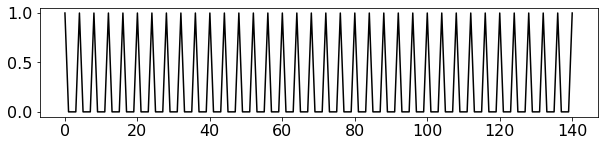

In [5]:
# Regular subsampling
sub = 4
iava = np.arange(par['nx'])[::sub]
Nsub = len(iava)
ava = np.zeros(par['nx'])
ava[iava] = 1
plt.figure(figsize=(10, 2))
plt.plot(ava, 'k')

# Create restriction operator
Rop = Restriction(dims=(par['nx'], par['nt']), iava=iava,  axis=0, dtype='float64')

y = Rop * x.ravel()
xadj = Rop.H * y.ravel()
y = y.reshape(Nsub, par['nt'])
xadj = xadj.reshape(par['nx'], par['nt'])

# Apply mask
ymask = Rop.mask(x.flatten())

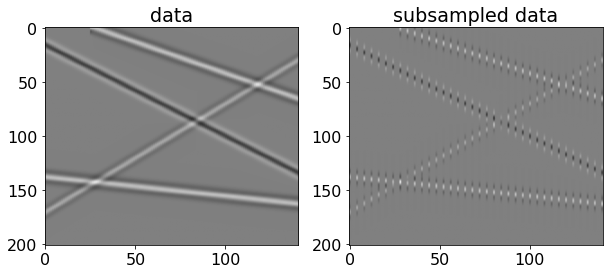

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(x.T, cmap='gray', aspect='auto', vmin=-2, vmax=2)
axs[0].set_title('data')
axs[1].imshow(ymask.data.T, cmap='gray', aspect='auto', vmin=-2, vmax=2)
axs[1].set_title('subsampled data');

In [7]:
nfft_f, nfft_k = 2**10, 2**10
FFTop = FFT2D(dims=[par['nx'], par['nt']], nffts=[nfft_k, nfft_f], sampling=[par['dx'], par['dt']])
f = FFTop.f2

X = FFTop * x.flatten()
X = np.reshape(X, (nfft_k, nfft_f))
Y = FFTop * ymask.flatten()
Y = np.reshape(Y, (nfft_k, nfft_f))

In [8]:
%%time
xinvlow, xinv, xinvrefined, Xinvlow, Xinv, Xinvrefined = \
        masked_interpolation(y, nx, dt, dx, nfft_f, nfft_k, sub,
                             vel=1500, critical=1.00, koffset=0.0, fmax=15., 
                             solver='FISTA')

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 28341 rows and 1048576 cols
eps = 1.000000e-02	tol = 1.000000e-10	niter = 20
alpha = 1.000000e+00	thresh = 5.000000e-03
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   0.00e+00+0.00e+00j    1.633e-01   2.767e+00   3.911e+00
     2   0.00e+00+0.00e+00j    1.303e-01   2.625e+00   2.905e-01
     3   0.00e+00+0.00e+00j    1.149e-01   2.522e+00   2.702e-01
     4   0.00e+00+0.00e+00j    1.065e-01   2.445e+00   2.539e-01
     5   0.00e+00+0.00e+00j    1.008e-01   2.386e+00   2.395e-01
     6   0.00e+00-0.00e+00j    9.670e-02   2.341e+00   2.273e-01
     7   -0.00e+00+0.00e+00j    9.441e-02   2.303e+00   2.170e-01
     8   -0.00e+00+0.00e+00j    9.247e-02   2.273e+00   2.062e-01
     9   -0.00e+00+0.00e+00j    9.063e-02   2.248e+00   1.969e-01
    10   -0.00e+00+

/opt/anaconda3/envs/pylops/lib/python3.9/site-packages/numpy/lib/shape_base.py:260: ComplexWarning: Casting complex values to real discards the imaginary part
  arr[_make_along_axis_idx(arr_shape, indices, axis)] = values


FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 7236 rows and 1048576 cols
eps = 1.000000e-02	tol = 1.000000e-10	niter = 20
alpha = 1.392183e+00	thresh = 6.960915e-03
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   0.00e+00+0.00e+00j    9.105e+01   1.056e+02   1.215e+01
     2   0.00e+00+0.00e+00j    4.769e+01   7.026e+01   8.093e+00
     3   0.00e+00+0.00e+00j    2.256e+01   5.189e+01   6.986e+00
     4   0.00e+00+0.00e+00j    1.079e+01   4.498e+01   5.315e+00
     5   0.00e+00+0.00e+00j    6.061e+00   4.326e+01   3.674e+00
     6   0.00e+00+0.00e+00j    4.165e+00   4.289e+01   2.465e+00
     7   0.00e+00+0.00e+00j    3.222e+00   4.246e+01   1.847e+00
     8   0.00e+00+0.00e+00j    2.657e+00   4.183e+01   1.633e+00
     9   0.00e+00+0.00e+00j    2.326e+00   4.122e+01   1.516e+00
    10   0.00e+00+0.00e

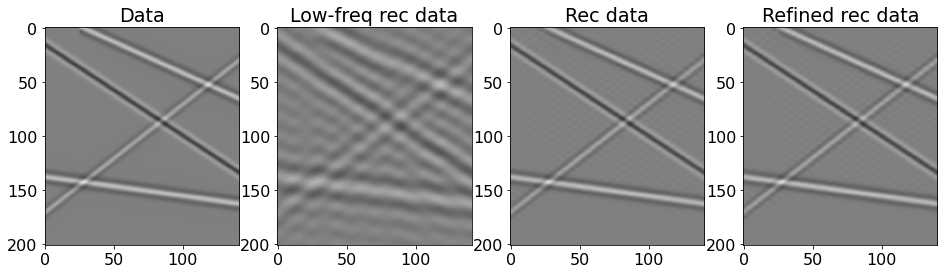

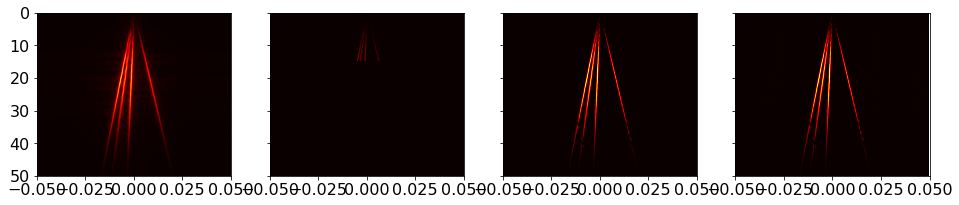

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(xinvlow.T, cmap='gray', vmin=-.2, vmax=.2)
axs[1].set_title('Low-freq rec data')
axs[1].axis('tight')
axs[2].imshow(xinv.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Rec data')
axs[2].axis('tight');
axs[3].imshow(xinvrefined.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Refined rec data')
axs[3].axis('tight')

fig,axes = plt.subplots(1, 4, sharey=True, figsize=(16, 3))
axes[0].imshow(np.fft.fftshift(np.abs(X.T)), cmap='hot',aspect='auto', vmin=0, vmax=1e0,
               extent=(FFTop.f1[nfft_k//2], FFTop.f1[nfft_k//2-1], FFTop.f2[nfft_f//2-1], FFTop.f2[nfft_f//2]))
#axes[0].plot(f/v, f,'w'), axes[0].plot(f/v, -f,'w')
axes[0].set_xlim(-1/(2*dx), 1/(2*dx))
axes[1].imshow(np.fft.fftshift(np.abs(Xinvlow.T)), cmap='hot', aspect='auto', vmin=0, vmax=1e0,
               extent=(FFTop.f1[nfft_k//2], FFTop.f1[nfft_k//2-1], FFTop.f2[nfft_f//2-1], FFTop.f2[nfft_f//2]))
#axes[1].plot(f/v, f,'w'), axes[1].plot(f/v, -f,'w')
axes[1].set_xlim(-1/(2*dx), 1/(2*dx))
axes[2].imshow(np.fft.fftshift(np.abs(Xinv.T)), cmap='hot', aspect='auto', vmin=0, vmax=1e0,
               extent=(FFTop.f1[nfft_k//2], FFTop.f1[nfft_k//2-1], FFTop.f2[nfft_f//2-1], FFTop.f2[nfft_f//2]))
axes[2].set_xlim(-1/(2*dx), 1/(2*dx))
axes[2].set_ylim(50, 0);
axes[3].imshow(np.fft.fftshift(np.abs(Xinvrefined.T)), cmap='hot', aspect='auto', vmin=0, vmax=1e0,
               extent=(FFTop.f1[nfft_k//2], FFTop.f1[nfft_k//2-1], FFTop.f2[nfft_f//2-1], FFTop.f2[nfft_f//2]))
axes[3].set_xlim(-1/(2*dx), 1/(2*dx))
axes[3].set_ylim(50, 0);

In [10]:
%%time
xinvlow_irls, xinv_irls, xinvrefined_irls, Xinvlow_irls, Xinv_irls, Xinvrefined_irls = \
    masked_interpolation(y, nx, dt, dx, nfft_f, nfft_k, sub,
                         vel=1500, critical=1.00, koffset=0.0, fmax=15., 
                         solver='IRLS')

use IRLS
use IRLS
use IRLS
CPU times: user 1min 20s, sys: 8.69 s, total: 1min 29s
Wall time: 24.6 s


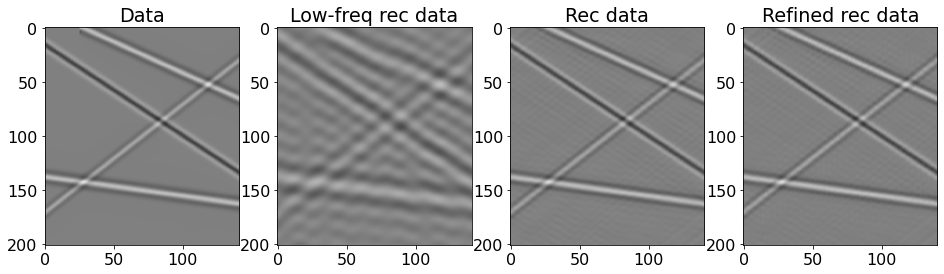

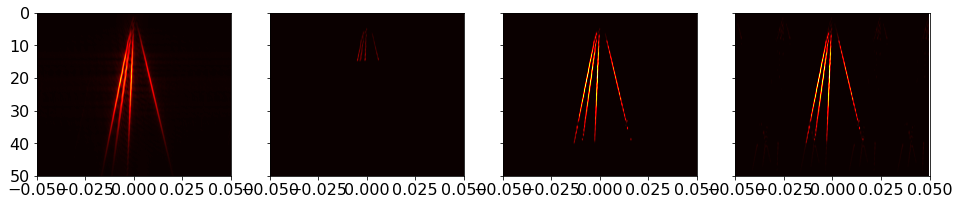

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(xinvlow_irls.T, cmap='gray', vmin=-.2, vmax=.2)
axs[1].set_title('Low-freq rec data')
axs[1].axis('tight')
axs[2].imshow(xinv_irls.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Rec data')
axs[2].axis('tight');
axs[3].imshow(xinvrefined_irls.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Refined rec data')
axs[3].axis('tight')

fig,axes = plt.subplots(1, 4, sharey=True, figsize=(16, 3))
axes[0].imshow(np.fft.fftshift(np.abs(X.T)), cmap='hot',aspect='auto', vmin=0, vmax=1e0,
               extent=(FFTop.f1[nfft_k//2], FFTop.f1[nfft_k//2-1], FFTop.f2[nfft_f//2-1], FFTop.f2[nfft_f//2]))
#axes[0].plot(f/v, f,'w'), axes[0].plot(f/v, -f,'w')
axes[0].set_xlim(-1/(2*dx), 1/(2*dx))
axes[1].imshow(np.fft.fftshift(np.abs(Xinvlow_irls.T)), cmap='hot', aspect='auto', vmin=0, vmax=1e0,
               extent=(FFTop.f1[nfft_k//2], FFTop.f1[nfft_k//2-1], FFTop.f2[nfft_f//2-1], FFTop.f2[nfft_f//2]))
#axes[1].plot(f/v, f,'w'), axes[1].plot(f/v, -f,'w')
axes[1].set_xlim(-1/(2*dx), 1/(2*dx))
axes[2].imshow(np.fft.fftshift(np.abs(Xinv_irls.T)), cmap='hot', aspect='auto', vmin=0, vmax=1e0,
               extent=(FFTop.f1[nfft_k//2], FFTop.f1[nfft_k//2-1], FFTop.f2[nfft_f//2-1], FFTop.f2[nfft_f//2]))
axes[2].set_xlim(-1/(2*dx), 1/(2*dx))
axes[2].set_ylim(50, 0);
axes[3].imshow(np.fft.fftshift(np.abs(Xinvrefined_irls.T)), cmap='hot', aspect='auto', vmin=0, vmax=1e0,
               extent=(FFTop.f1[nfft_k//2], FFTop.f1[nfft_k//2-1], FFTop.f2[nfft_f//2-1], FFTop.f2[nfft_f//2]))
axes[3].set_xlim(-1/(2*dx), 1/(2*dx))
axes[3].set_ylim(50, 0);

In [12]:
print(np.linalg.norm(x-xinvrefined), np.linalg.norm(x-xinvrefined_irls))

4.70835765028149 5.876530306574694
